In [1]:
import pandas as pd
station_precip = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/cali_precipitation.csv', index_col=0, parse_dates=True)

import numpy as np
import xarray as xr
modis001 = xr.open_dataset("D:/Desktop/mentor_research/data_modis/nyc_modis_data_2015_present.nc")
modis001 = modis001.sel(time=modis001.time < np.datetime64("2024-12-01"))
modis001
precip001 = xr.open_dataset("D:/Desktop/mentor_research/data_imerg/nyc_precipitation_data_2015_to_present.nc")
precip001
combined001 = xr.merge([modis001, precip001])
combined001
# 1. 将 precipitation < 0 的值设为 NaN
combined001["precipitation"] = combined001["precipitation"].where(combined001["precipitation"] >= 0)

# 2. 删除变量 snow_cover（如果存在）
if "snow_cover" in combined001.data_vars:
    combined001 = combined001.drop_vars("snow_cover")

# 可选：查看结果
print(combined001)

combined005 = combined001.coarsen(lat=5, lon=5, boundary="trim").mean()
combined005

<xarray.Dataset>
Dimensions:              (time: 119, lat: 50, lon: 100)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                  (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    surface_temperature  (time, lat, lon) float32 ...
    vegetation_index     (time, lat, lon) float32 ...
    evapotranspiration   (time, lat, lon) float32 ...
    dem                  (time, lat, lon) float32 ...
    burned_area          (time, lat, lon) float32 ...
    precipitation        (time, lat, lon) float32 nan 0.0 0.0 ... 0.01102 0.0
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly avera

<xarray.Dataset>
Dimensions:              (time: 119, lat: 10, lon: 20)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.08 -74.03 -73.98 ... -73.17 -73.12
  * lat                  (lat) float32 40.42 40.47 40.52 ... 40.78 40.83 40.88
Data variables:
    surface_temperature  (time, lat, lon) float32 67.77 75.86 73.39 ... 0.0 0.0
    vegetation_index     (time, lat, lon) float32 0.1851 0.1869 ... -0.3 -0.3
    evapotranspiration   (time, lat, lon) float32 394.5 394.6 ... 3.277e+03
    dem                  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    burned_area          (time, lat, lon) float32 -0.12 -0.12 ... -2.0 -2.0
    precipitation        (time, lat, lon) float32 0.0009419 0.05037 ... 0.005709
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

In [2]:
station_precip.head()

,time,lat,lon,cali_precipitation
0,2015-01-01,40.6386,-73.7622,1.226127
1,2015-01-01,40.6825,-74.1694,1.020618
2,2015-02-01,40.6386,-73.7622,0.746125
3,2015-02-01,40.6825,-74.1694,0.654050
4,2015-03-01,40.6386,-73.7622,0.826347


In [3]:
station_precip.head()
#选取2023/1/1
station_precip_202311 = station_precip[station_precip['time']=='2023-01-01']
station_precip_202311

,time,lat,lon,cali_precipitation
258,2023-01-01,40.6386,-73.7622,0.709386
259,2023-01-01,40.6825,-74.1694,0.781957
260,2023-01-01,40.7769,-73.8740,0.789093


In [4]:
# combined005和combined001选取2023年一年的数据，转成dataframe
combined001_2023 = combined001.sel(time=slice("2023-01-01", "2023-01-01"))
combined005_2023 = combined005.sel(time=slice("2023-01-01", "2023-01-01"))
combined001_202311_df = combined001_2023.to_dataframe().reset_index()
combined005_202311_df = combined005_2023.to_dataframe().reset_index()
combined001_202311_df = combined001_202311_df.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]
combined005_202311_df = combined005_202311_df.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]
combined005_202311_df

,lat,lon,precipitation
0,40.420406,-74.079796,0.000220
1,40.420406,-74.029289,0.099096
2,40.420406,-73.978790,1.215872
3,40.420406,-73.928284,3.584634
4,40.420406,-73.877777,1.927381
...,...,...,...
195,40.879597,-73.322220,2.853360
196,40.879597,-73.271721,0.986458
197,40.879597,-73.221214,0.184242
198,40.879597,-73.170708,0.009945


Training data shape: (200, 3)
Prediction grid shape: (5000, 3)
Training Gaussian Process model...
Training complete!
Optimized kernel parameters: 2.63**2 * RBF(length_scale=[0.0441, 0.0485])
Validation MSE: 3.8865
Validation R² score: 0.3222
Retraining model on the full training set...
Retraining complete!
Predicting on target grid...
Prediction complete!
Prediction results saved to 'downscaled_precipitation.csv'


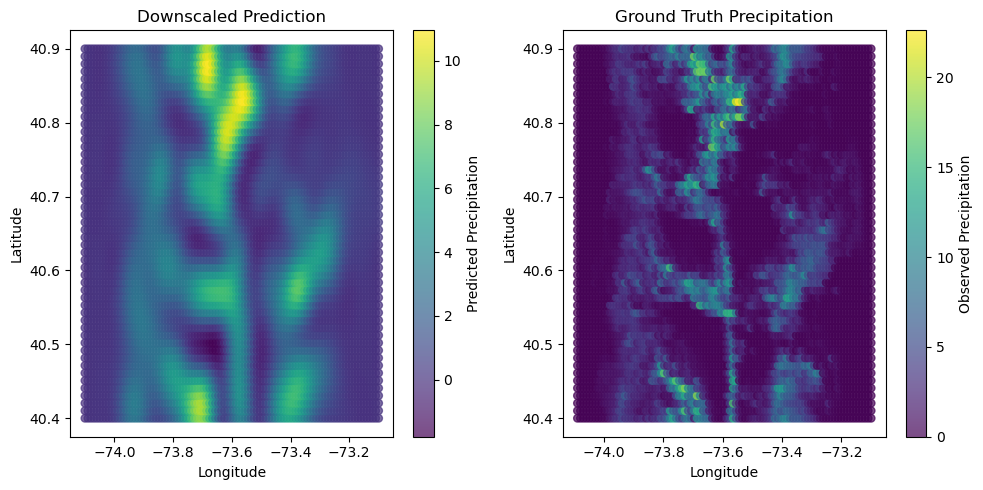

Total runtime: 5.40 seconds
Downscaling analysis complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time
# combined005和combined001选取2023年一年的数据，转成dataframe
combined001_2023 = combined001.sel(time=slice("2023-01-01", "2023-01-01"))
combined005_2023 = combined005.sel(time=slice("2023-01-01", "2023-01-01"))
combined001_202311_df = combined001_2023.to_dataframe().reset_index()
combined005_202311_df = combined005_2023.to_dataframe().reset_index()
combined001_202311_df = combined001_202311_df.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]
combined005_202311_df = combined005_202311_df.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]
combined005_202311_df
# Start timing
start_time = time.time()

# 1. Load data
# Assume the data is already loaded as DataFrames
train_data = combined005_202311_df.copy()
pred_grid = combined001_202311_df.copy()

print(f"Training data shape: {train_data.shape}")
print(f"Prediction grid shape: {pred_grid.shape}")

# 2. Prepare training data
X_train = train_data[['lat', 'lon']].values
y_train = train_data['precipitation'].values

# 3. Prepare target grid for prediction
X_pred = pred_grid[['lat', 'lon']].values

# 4. Split a portion of training data for validation
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 5. Configure Gaussian Process model
# Define kernel: constant kernel × RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))

# Create Gaussian Process Regressor
gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.1,  # Add some noise for numerical stability
    n_restarts_optimizer=10,
    random_state=42
)

# 6. Train the model
print("Training Gaussian Process model...")
gp.fit(X_train_fit, y_train_fit)
print("Training complete!")
print(f"Optimized kernel parameters: {gp.kernel_}")

# 7. Evaluate model performance on validation set
y_val_pred, y_val_std = gp.predict(X_val, return_std=True)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R² score: {val_r2:.4f}")

# 8. Retrain model on full training set
print("Retraining model on the full training set...")
gp.fit(X_train, y_train)
print("Retraining complete!")

# 9. Predict on target grid
print("Predicting on target grid...")
y_pred, y_std = gp.predict(X_pred, return_std=True)
print("Prediction complete!")

# 10. Add predictions to the prediction grid
pred_grid['precipitation_pred'] = y_pred
pred_grid['precipitation_std'] = y_std

# 11. Save prediction results
pred_grid.to_csv('downscaled_precipitation.csv', index=False)
print("Prediction results saved to 'downscaled_precipitation.csv'")

# 12. Visualize results
plt.figure(figsize=(12, 10))

# 12.1 Training data
plt.subplot(221)
sc = plt.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap='viridis', 
           s=30, alpha=0.7, vmin=np.min(y_train), vmax=np.max(y_train))
plt.colorbar(sc, label='Precipitation (Training Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation in Training Data')
plt.grid(True, alpha=0.3)

# 12.2 Predictions on grid
plt.subplot(222)
sc = plt.scatter(X_pred[:, 1], X_pred[:, 0], c=y_pred, cmap='viridis', 
           s=30, alpha=0.7, vmin=np.min(y_train), vmax=np.max(y_train))
plt.colorbar(sc, label='Precipitation (Predicted)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Downscaled Precipitation Prediction')
plt.grid(True, alpha=0.3)

# 12.3 Prediction uncertainty
plt.subplot(223)
sc = plt.scatter(X_pred[:, 1], X_pred[:, 0], c=y_std, cmap='Reds', 
           s=30, alpha=0.7)
plt.colorbar(sc, label='Standard Deviation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prediction Uncertainty (Standard Deviation)')
plt.grid(True, alpha=0.3)

# 12.4 Validation scatter plot
plt.subplot(224)
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f'Validation Set: Predicted vs Observed (R² = {val_r2:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('precipitation_downscaling_results.png', dpi=300)
plt.close()

# 13. Compare predicted vs actual downscaled precipitation
plt.figure(figsize=(10, 5))

# 13.1 Predicted precipitation
plt.subplot(1, 2, 1)
sc = plt.scatter(pred_grid['lon'], pred_grid['lat'],
                 c=pred_grid['precipitation_pred'],
                 cmap='viridis', s=30, alpha=0.7)
plt.colorbar(sc, label='Predicted Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Downscaled Prediction')

# 13.2 Ground truth (actual) precipitation
plt.subplot(1, 2, 2)
sc = plt.scatter(pred_grid['lon'], pred_grid['lat'],
                 c=pred_grid['precipitation'],
                 cmap='viridis', s=30, alpha=0.7)
plt.colorbar(sc, label='Observed Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ground Truth Precipitation')

plt.tight_layout()
plt.savefig('predicted_vs_actual_precipitation.png', dpi=300)
plt.show()

# Print total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

print("Downscaling analysis complete!")


2023年1月1日的数据貌似也有相关性，那我把这一年的结果都训练出来

In [10]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time

# Assume combined001 and combined005 are already loaded xarray datasets

# Storage for monthly results
monthly_predictions = []

# Loop over each month in 2023
for month in range(1, 13):
    start_time = time.time()
    month_str = f"2023-{month:02d}-01"
    
    # Select monthly data
    combined001_month = combined001.sel(time=month_str)
    combined005_month = combined005.sel(time=month_str)

    # Convert to DataFrame
    df_001 = combined001_month.to_dataframe().reset_index()
    df_005 = combined005_month.to_dataframe().reset_index()

    # Drop NaNs and keep necessary columns
    df_001 = df_001.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]
    df_005 = df_005.dropna(subset=["lat", "lon"])[['lat', 'lon', 'precipitation']]

    if df_001.empty or df_005.empty:
        continue  # Skip empty months

    X_train = df_005[['lat', 'lon']].values
    y_train = df_005['precipitation'].values
    X_pred = df_001[['lat', 'lon']].values

    # Fit/validation split
    X_train_fit, X_val, y_train_fit, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=5, random_state=42)

    gp.fit(X_train_fit, y_train_fit)
    val_r2 = r2_score(y_val, gp.predict(X_val))

    # Retrain on full data and predict
    gp.fit(X_train, y_train)
    y_pred, y_std = gp.predict(X_pred, return_std=True)

    # Build result DataFrame
    df_001['precipitation_pred'] = y_pred
    df_001['precipitation_std'] = y_std
    df_001['time'] = pd.to_datetime(month_str)

    monthly_predictions.append(df_001)

# Concatenate all months
results_all_months = pd.concat(monthly_predictions, ignore_index=True)

# Convert to xarray Dataset
ds_monthly = results_all_months.set_index(['time', 'lat', 'lon']).to_xarray()

# Save to NetCDF
output_path = "downscaled_precipitation_2023.nc"
ds_monthly.to_netcdf(output_path)

output_path


'downscaled_precipitation_2023.nc'

In [12]:
downscaled_2023 = xr.open_dataset(output_path)
downscaled_2023

<xarray.Dataset>
Dimensions:             (lon: 100, lat: 50, time: 12)
Coordinates:
  * lon                 (lon) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                 (lat) float64 40.4 40.41 40.42 ... 40.88 40.89 40.9
  * time                (time) datetime64[ns] 2023-01-01 ... 2023-12-01
Data variables:
    precipitation       (time, lat, lon) float32 ...
    precipitation_pred  (time, lat, lon) float64 ...
    precipitation_std   (time, lat, lon) float64 ...

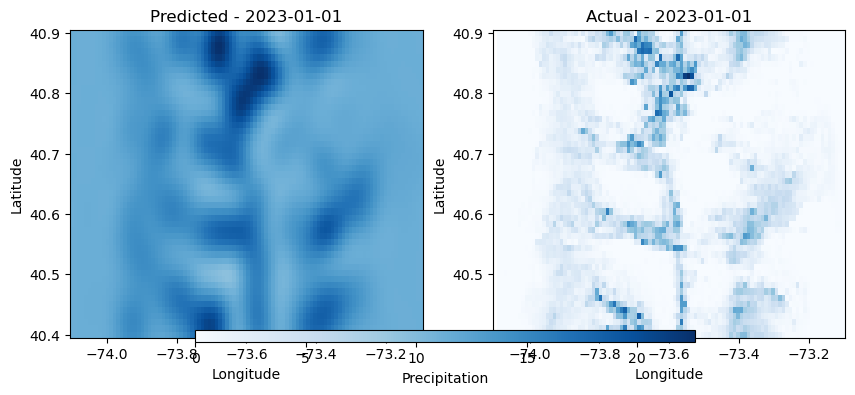

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import xarray as xr
from IPython.display import HTML

# 提取数据
tp_pred = downscaled_2023['precipitation_pred']
tp_actual = downscaled_2023['precipitation']
times = downscaled_2023.time.values

# 设置图形基础
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])

# 初始化首帧
tp_pred.isel(time=0).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
img1 = tp_actual.isel(time=0).plot(ax=axes[1], cmap="Blues", add_colorbar=False)

axes[0].set_title("Predicted")
axes[1].set_title("Actual")
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# 添加 colorbar
plt.colorbar(img1, cax=cbar_ax, orientation='horizontal', label='Precipitation')

# 更新函数
def update(i):
    axes[0].clear()
    axes[1].clear()
    tp_pred.isel(time=i).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
    tp_actual.isel(time=i).plot(ax=axes[1], cmap="Blues", add_colorbar=False)
    axes[0].set_title(f"Predicted - {np.datetime_as_string(times[i], unit='D')}")
    axes[1].set_title(f"Actual - {np.datetime_as_string(times[i], unit='D')}")
    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=len(times), interval=300)

# ✅ Jupyter 中播放动画：
HTML(ani.to_jshtml())


In [14]:
from sklearn.metrics import r2_score
import numpy as np

# 存储结果
correlations = []
r2_scores = []
time_labels = []

# 遍历每个时间点计算对应指标
for t in times:
    pred_values = tp_pred.sel(time=t).values.flatten()
    actual_values = tp_actual.sel(time=t).values.flatten()
    
    # 去除 NaN 对应位置
    valid_mask = (~np.isnan(pred_values)) & (~np.isnan(actual_values))
    y_pred = pred_values[valid_mask]
    y_true = actual_values[valid_mask]
    
    # Pearson 相关系数
    if len(y_true) > 0:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
    else:
        corr = np.nan
        r2 = np.nan

    correlations.append(corr)
    r2_scores.append(r2)
    time_labels.append(str(np.datetime_as_string(t, unit='D')))

correlations, r2_scores

metrics_df = pd.DataFrame({
    "Time": time_labels,
    "Pearson Correlation": correlations,
    "R² Score": r2_scores
})

metrics_df


,Time,Pearson Correlation,R² Score
0,2023-01-01,0.812937,0.657154
1,2023-02-01,0.773171,0.592755
2,2023-03-01,0.776556,0.598939
3,2023-04-01,0.775117,0.597480
4,2023-05-01,0.786225,0.615296
5,2023-06-01,0.774006,0.594838
6,2023-07-01,0.810707,0.653354
7,2023-08-01,0.758765,0.571884
8,2023-09-01,0.778694,0.602844
9,2023-10-01,0.769767,0.586714


In [35]:
# calibration
import pandas as pd
import numpy as np

# 处理station数据（日均值要用非0值求）
cali_precip = pd.read_csv("D:/Desktop/mentor_research/data_station/nyc_central_park_precipitation.csv")
cali_precip['time'] = pd.to_datetime(cali_precip['time'])
cali_precip['month'] = cali_precip['time'].dt.to_period('M').dt.to_timestamp()

# 获取所有唯一组合
all_combinations = (
    cali_precip[['month', 'lat', 'lon']]
    .drop_duplicates()
    .sort_values(['month', 'lat', 'lon'])
)

# 对非零值做均值
nonzero_mean = (
    cali_precip[cali_precip['precipitation'] > 0]
    .groupby(['month', 'lat', 'lon'])['precipitation']
    .mean()
    .reset_index(name='cali_precipitation')
)

# 与所有组合进行 merge（保留所有格点）
cali_precip = pd.merge(
    all_combinations,
    nonzero_mean,
    how='left',
    on=['month', 'lat', 'lon']
)

# 如果你希望全为 0 的情况设为 0（而不是 NaN），加这一步：
cali_precip['cali_precipitation'] = cali_precip['cali_precipitation'].fillna(0)

# 最后统一列名
cali_precip.rename(columns={'month': 'time'}, inplace=True)
cali_precip

,time,lat,lon,cali_precipitation
0,2015-01-01,40.6386,-73.7622,1.226127
1,2015-01-01,40.6825,-74.1694,1.020618
2,2015-02-01,40.6386,-73.7622,0.746125
3,2015-02-01,40.6825,-74.1694,0.654050
4,2015-03-01,40.6386,-73.7622,0.826347
...,...,...,...,...
329,2025-02-01,40.7769,-73.8740,0.736600
330,2025-03-01,40.6825,-74.1694,1.454150
331,2025-03-01,40.7769,-73.8740,1.447800
332,2025-04-01,40.6825,-74.1694,0.427182


In [31]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
results_df = downscaled_2023.to_dataframe().reset_index()

# 保证时间格式正确
cali_precip['time'] = pd.to_datetime(cali_precip['time'])
results_df['time'] = pd.to_datetime(results_df['time'])

# 提取 results_df 中可用时间点
valid_times = results_df['time']

# 筛选 cali_precip 中在有效时间点范围内的数据
cali_in_range = cali_precip[cali_precip['time'].isin(valid_times)].copy()
cali_in_range.sort_values(by=['time', 'lat', 'lon'], inplace=True)

# 添加新列用于填入预测值
cali_in_range['matched_prediction'] = np.nan

# 对每一个时间点，匹配最近 (lat, lon)
for t in cali_in_range['time'].unique():
    cali_t = cali_in_range[cali_in_range['time'] == t]
    results_t = results_df[results_df['time'] == t]

    if results_t.empty:
        continue

    # 构建 KDTree 匹配空间最近点
    tree = cKDTree(results_t[['lat', 'lon']].values)
    distances, indices = tree.query(cali_t[['lat', 'lon']].values)

    # 获取对应预测值
    matched_preds = results_t.iloc[indices]['precipitation_pred'].values

    # 写入结果
    cali_in_range.loc[cali_t.index, 'matched_prediction'] = matched_preds

print(cali_in_range.head())
# 准备训练数据，去掉 NaN
calibration_df = cali_in_range.dropna(subset=['cali_precipitation', 'matched_prediction'])

X = calibration_df[['matched_prediction']].values
y = calibration_df['cali_precipitation'].values

from sklearn.linear_model import LinearRegression
import numpy as np
# 筛选非零降水数据进行校准
mask = y > 0
X_filtered = X[mask]
y_filtered = y[mask]

# 拟合线性回归
lr_model = LinearRegression()
lr_model.fit(X_filtered, y_filtered)

beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]

print("Linear regression calibration formula (y > 0):")
print(f"calibrated_prediction = {beta_0:.12f} + {beta_1:.12f} × matched_prediction")

# 创建副本并进行校准
results_combined = results_df.copy()

results_combined['calibrated_precipitation'] = beta_0 + beta_1 * results_combined['precipitation_pred']
results_combined['calibrated_precipitation'] = np.where(results_combined['calibrated_precipitation'] < 0, 0, results_combined['calibrated_precipitation'])
results_combined['time'] = pd.to_datetime(results_combined['time'])

# 设置三维索引
results_indexed = results_combined.set_index(['time', 'lat', 'lon'])

# 转换为 xarray Dataset
results_combined = xr.Dataset.from_dataframe(results_indexed)

# 查看结果结构
print(results_combined)


          time      lat      lon  cali_precipitation  matched_prediction
258 2023-01-01  40.6386 -73.7622            0.709386            1.414601
259 2023-01-01  40.6825 -74.1694            0.781957            0.030233
260 2023-01-01  40.7769 -73.8740            0.789093            2.079589
261 2023-02-01  40.6386 -73.7622            0.355600            1.790900
262 2023-02-01  40.6825 -74.1694            0.358140            0.002356
Linear regression calibration formula (y > 0):
calibrated_prediction = 1.102978554971 + 0.000502206278 × matched_prediction
<xarray.Dataset>
Dimensions:                   (time: 12, lat: 50, lon: 100)
Coordinates:
  * time                      (time) datetime64[ns] 2023-01-01 ... 2023-12-01
  * lat                       (lat) float64 40.4 40.41 40.42 ... 40.89 40.9
  * lon                       (lon) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
Data variables:
    precipitation             (time, lat, lon) float32 nan 0.0 ... 0.008051 0.0
    precipitation

In [32]:
results_combined

<xarray.Dataset>
Dimensions:                   (time: 12, lat: 50, lon: 100)
Coordinates:
  * time                      (time) datetime64[ns] 2023-01-01 ... 2023-12-01
  * lat                       (lat) float64 40.4 40.41 40.42 ... 40.89 40.9
  * lon                       (lon) float64 -74.1 -74.09 -74.08 ... -73.11 -73.1
Data variables:
    precipitation             (time, lat, lon) float32 nan 0.0 ... 0.008051 0.0
    precipitation_pred        (time, lat, lon) float64 -0.06477 ... -0.03499
    precipitation_std         (time, lat, lon) float64 1.332 1.137 ... 1.521
    calibrated_precipitation  (time, lat, lon) float64 1.103 1.103 ... 1.103

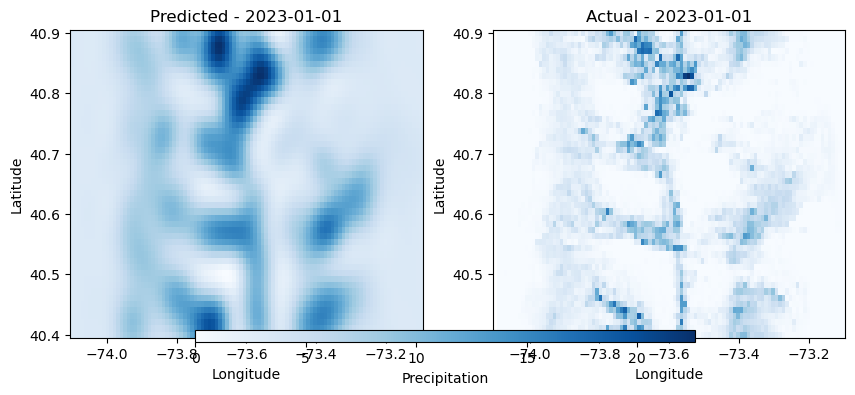

In [45]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import xarray as xr
from IPython.display import HTML

# 提取数据
# 替代 np.where，保持 xarray 的坐标结构
tp_pred = results_combined['calibrated_precipitation'].where(
    results_combined['calibrated_precipitation'] >= 0, 0
)
tp_actual = results_combined['precipitation']
times = results_combined.time.values

# 设置图形基础
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])

# 初始化首帧
tp_pred.isel(time=0).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
img1 = tp_actual.isel(time=0).plot(ax=axes[1], cmap="Blues", add_colorbar=False)

axes[0].set_title("Predicted")
axes[1].set_title("Actual")
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# 添加 colorbar
plt.colorbar(img1, cax=cbar_ax, orientation='horizontal', label='Precipitation')

# 更新函数
def update(i):
    axes[0].clear()
    axes[1].clear()
    tp_pred.isel(time=i).plot(ax=axes[0], cmap="Blues", add_colorbar=False)
    tp_actual.isel(time=i).plot(ax=axes[1], cmap="Blues", add_colorbar=False)
    axes[0].set_title(f"Predicted - {np.datetime_as_string(times[i], unit='D')}")
    axes[1].set_title(f"Actual - {np.datetime_as_string(times[i], unit='D')}")
    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=len(times), interval=300)

# ✅ Jupyter 中播放动画：
HTML(ani.to_jshtml())

ani.save("precipitation_comparison.gif", writer="pillow", fps=3)

In [34]:
from sklearn.metrics import r2_score
import numpy as np

# 存储结果
correlations = []
r2_scores = []
time_labels = []

tp_pred = results_combined['calibrated_precipitation']
tp_actual = results_combined['precipitation']
# 遍历每个时间点计算对应指标
for t in times:
    pred_values = tp_pred.sel(time=t).values.flatten()
    actual_values = tp_actual.sel(time=t).values.flatten()
    
    # 去除 NaN 对应位置
    valid_mask = (~np.isnan(pred_values)) & (~np.isnan(actual_values))
    y_pred = pred_values[valid_mask]
    y_true = actual_values[valid_mask]
    
    # Pearson 相关系数
    if len(y_true) > 0:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
    else:
        corr = np.nan
        r2 = np.nan

    correlations.append(corr)
    r2_scores.append(r2)
    time_labels.append(str(np.datetime_as_string(t, unit='D')))

correlations, r2_scores

metrics_df = pd.DataFrame({
    "Time": time_labels,
    "Pearson Correlation": correlations,
    "R² Score": r2_scores
})

metrics_df


,Time,Pearson Correlation,R² Score
0,2023-01-01,0.812937,-0.097282
1,2023-02-01,0.773171,-0.097912
2,2023-03-01,0.776556,-0.132669
3,2023-04-01,0.775117,-0.144969
4,2023-05-01,0.786225,-0.140146
5,2023-06-01,0.774006,-0.136022
6,2023-07-01,0.810707,-0.127246
7,2023-08-01,0.758765,-0.135701
8,2023-09-01,0.778694,-0.150339
9,2023-10-01,0.769767,-0.124347


# 逐年校准R2变负数，现逐月校准

In [43]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.linear_model import LinearRegression

# 1. 转为 DataFrame
results_df = downscaled_2023.to_dataframe().reset_index()
results_df['time'] = pd.to_datetime(results_df['time'])
cali_precip['time'] = pd.to_datetime(cali_precip['time'])

# 2. 提取所有月份
all_months = results_df['time'].dt.to_period('M').sort_values()

# 3. 存储每月校准结果
monthly_calibrated = []

for month in all_months:
    month_time = pd.to_datetime(month.start_time)
    print(f"Processing: {month_time.date()}")

    # 本月数据筛选
    cali_t = cali_precip[cali_precip['time'] == month_time].copy()
    result_t = results_df[results_df['time'] == month_time].copy()

    if cali_t.empty or result_t.empty:
        continue

    # 最近邻匹配
    tree = cKDTree(result_t[['lat', 'lon']].values)
    distances, indices = tree.query(cali_t[['lat', 'lon']].values)
    matched_preds = result_t.iloc[indices]['precipitation_pred'].values
    cali_t['matched_prediction'] = matched_preds

    # 拟合回归（非零数据）
    valid = cali_t[cali_t['cali_precipitation'] > 0].dropna()

    X = valid[['matched_prediction']].values
    y = valid['cali_precipitation'].values
    model = LinearRegression().fit(X, y)

    beta_0 = model.intercept_
    beta_1 = model.coef_[0]

    # 应用于该月所有 prediction
    result_t['calibrated_precipitation'] = beta_0 + beta_1 * result_t['precipitation_pred']
    result_t['calibrated_precipitation'] = result_t['calibrated_precipitation'].clip(lower=0)

    # 存储
    monthly_calibrated.append(result_t)

# 4. 合并所有月结果
results_all = pd.concat(monthly_calibrated).sort_values(by=['time', 'lat', 'lon'])

# 5. 转为 xarray.Dataset 并保存
ds_monthly = results_all.set_index(['time', 'lat', 'lon']).to_xarray()
ds_monthly.to_netcdf("downscaled_precipitation_2023_monthly_calibrated.nc")

print("✅ Monthly calibration complete and saved.")


Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing: 2023-01-01
Processing:

MemoryError: Unable to allocate 4.47 GiB for an array with shape (2, 300000000) and data type float64